## Acoustic wave simulation in time domain

Loading plotting and Acoustic wave packages.

In [64]:
using SeisPlot, SeisAcoustic, PyPlot, LinearAlgebra

Create a simple two layers velocity model with constant density, size of this model is $101 \times 301$

In [55]:
nz = 101; nx = 301;
vel = 3000 * ones(101, 301);  # m/s
vel[51:end,:] .= 3500;  
rho = 2000 * ones(101, 301);  # kg/m^3

Plot the velocity model

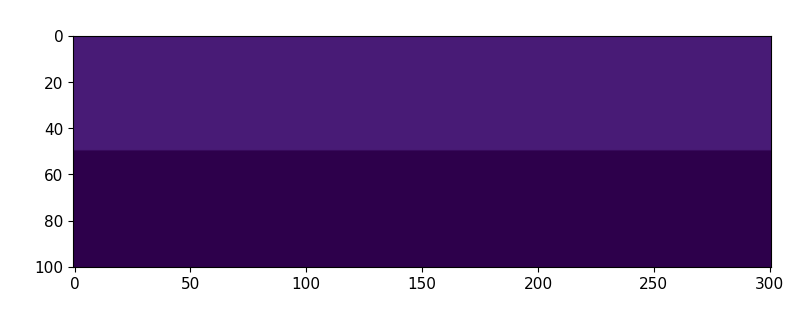

In [56]:
SeisPlotTX(vel, wbox=9, hbox=3);

Specify the boundary conditions

In [17]:
# number of PML layers
npml = 20;

# free surface for top boundary condition
free_surface = true;   

Grid size

In [21]:
# vertical and horizontal grid size
dz = 10; dx = 10;

# time step size and maximum modelling length
dt = 0.001; tmax = 2.0;  # use second as unit

Discretize acoustic wave-equation via finite difference method and generating stencil

In [22]:
params = TdParams(rho, vel, free_surface, dz, dx, dt, tmax;
         data_format=Float64, fd_flag="taylor", order=2, npml=20, apml=900.);

Initialize  a single point source, the first two parameters are the index location of this point source.

In [23]:
src = Source(2, 150, params; ot=0.0, fdom=20.0,
      type_flag="ricker", amp=100000, location_flag="index");

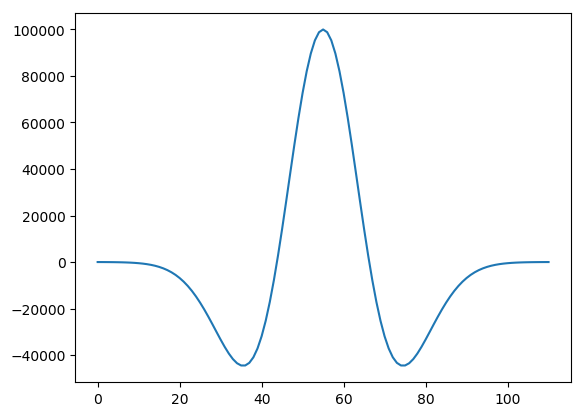

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x145eb27f0>

In [52]:
# plotting the source time function
plot(src.p)

Initialize the recording structure which require the locations of receivers

In [24]:
irx = collect(1:2:params.nx);
irz = 2 * ones(length(irx));
rec = Recordings(irz, irx, params);

Generate one shot gather

In [26]:
multi_step_forward!(rec, src, params);

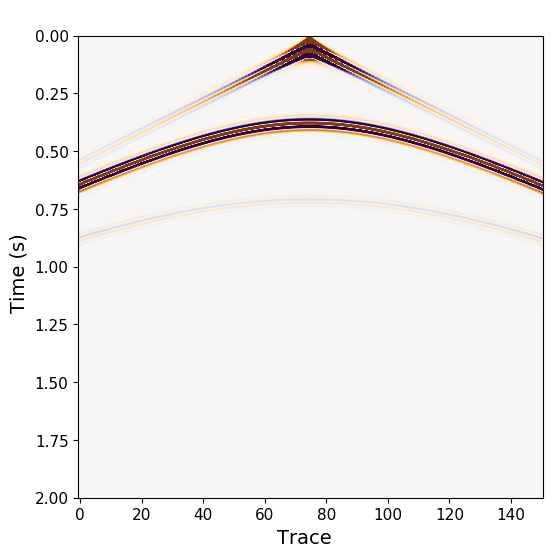

In [35]:
# plotting the shot gather
SeisPlotTX(rec.p, pclip=98, dy=0.001, ylabel="Time (s)", xlabel="Trace");

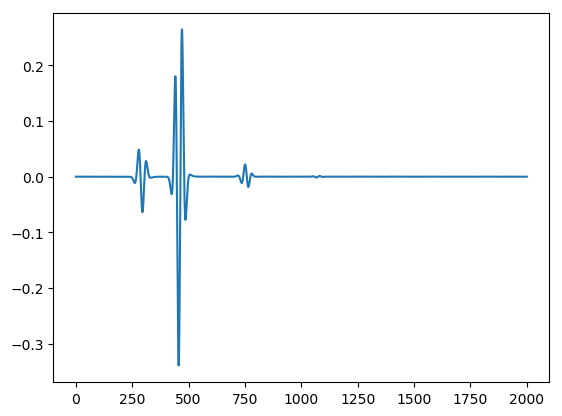

In [37]:
# plot one trace
plot(rec.p[:,40]);

This package also support simultaneous source modelling. The source term is consisted by a vector, each element of this vector is a source structure.

In [45]:
# initialize multi-sources
isx = collect(5:60:295);           # horizontal location
ns=length(isx); isz = 2*ones(ns);  # vertical location
ot  = 0.5*rand(ns);                # activation time
srcs = get_multi_sources(isz, isx, params; amp=100000, ot=ot, fdom=15); # get a vector of source

In [46]:
# forward modelling
multi_step_forward!(rec, srcs, params);

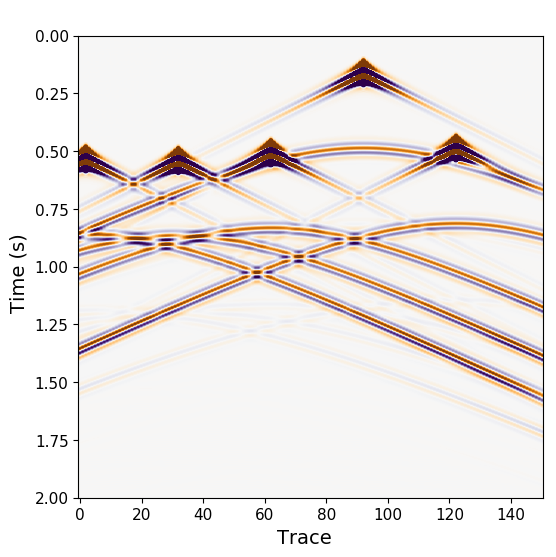

In [47]:
# plotting the blending data
SeisPlotTX(rec.p, pclip=98, dy=0.001, ylabel="Time (s)", xlabel="Trace");

## Gradient of Acoustic FWI 

In [53]:
# Using the 2-layers velocity model to generate observations
dobs= Recordings(irz, irx, params);
multi_step_forward!(dobs, src, params);

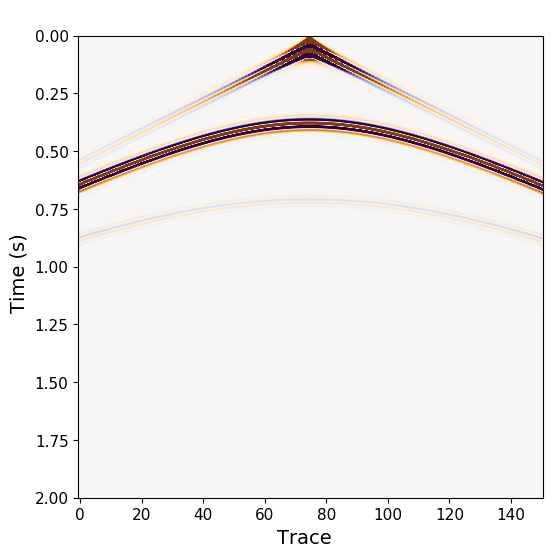

In [54]:
# plotting the recordings
SeisPlotTX(dobs.p, pclip=98, dy=0.001, ylabel="Time (s)", xlabel="Trace");

### Gradient via adjoint method 

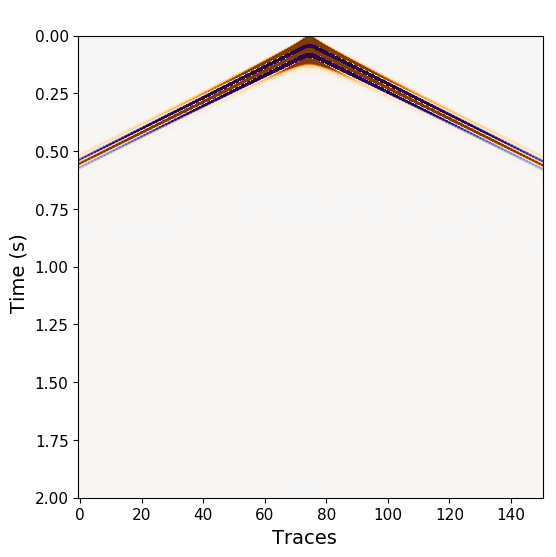

im

In [78]:
# initial velocity model
vel0 = 3000 * ones(nz, nx);
params0 = TdParams(rho, vel0, free_surface, dz, dx, dt, tmax; data_format=Float64);

# generate synthetic data and save the boundary value which will be used for source-side wavefield reconstruction
path_bnd = joinpath(homedir(), "Desktop/bnd.rsb");
path_wfd = joinpath(homedir(), "Desktop/wfd.rsb");
dsyn = Recordings(irz, irx, params0);

# forward modelling
multi_step_forward!(dsyn, src, params0, path_bnd=path_bnd, path_wfd=path_wfd);
SeisPlotTX(dsyn.p, xlabel="Traces", ylabel="Time (s)", dy=0.001);

In [79]:
# compute the residue
dres = get_residue(dsyn, dobs);
SeisPlotTX(dres.p, xlabel="Traces", ylabel="Time (s)", dy=0.001);

UndefVarError: UndefVarError: get_residue not defined

#### Compute gradient of one model parameter numerically
$$\frac{\partial J}{\partial m_l} = \frac{J(m_l + \delta m_l) - J(m_l - \delta m_l)}{2\delta m_l}$$
where the objective function $J$ is the $l2$ norm of the difference between synthetic data and observations.
$$
J = \frac{1}{2}|| d_{syn} - d_{obs}||_2^2
$$

In [57]:
# initial homogeneous velocity model
vel0    = 3000 * ones(nz, nx);

# model pertubation
delta_m = 1e-7;

In [58]:
# compute the derivative of objective function with respect to one model parameter
# the model parameter is limited to velocity model in constant density case.
iz = 51; ix = 151;

$$m_l + \delta m_l$$

In [59]:
vel0[iz,ix] = vel0[iz,ix] + delta_m;

In [61]:
# stencils corresponding to current model
params0 = TdParams(rho, vel0, free_surface, dz, dx, dt, tmax; data_format=Float64);

Generate synthetic data

In [62]:
# Using the 2-layers velocity model to generate observations
dsyn = Recordings(irz, irx, params0);
multi_step_forward!(dsyn, src, params0);

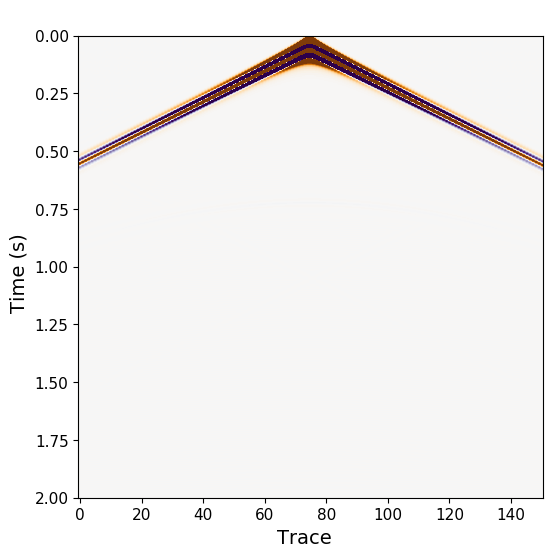

In [63]:
# plotting the synthetic data
SeisPlotTX(dsyn.p, pclip=98, dy=0.001, ylabel="Time (s)", xlabel="Trace");

Compute cost
$$
J(m_l + \delta m_l) = \frac{1}{2}|| d_{syn} - d_{obs}||_2^2
$$

In [65]:
dres = Recordings(irz, irx, params0);
for ir = 1 : dsyn.nr
    for it = 1 : dsyn.nt
        dres.p[it,ir] = dsyn.p[it,ir] - dobs.p[it,ir]
    end
end

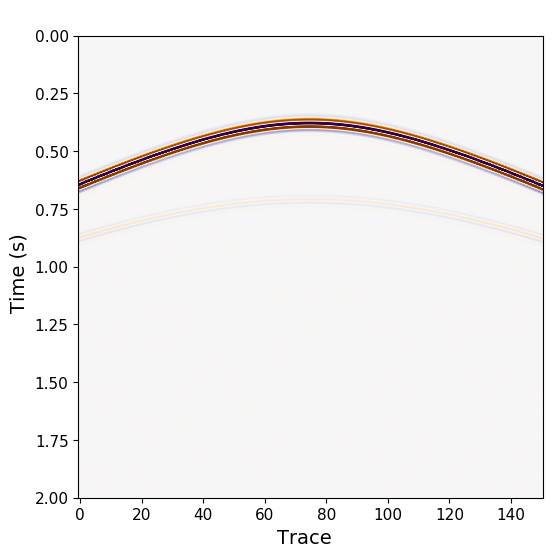

In [67]:
# plotting data residue 
SeisPlotTX(dres.p, pclip=99, dy=0.001, ylabel="Time (s)", xlabel="Trace");

In [68]:
# objective function
J_plus = (norm(dres.p))^2 / 2.0

144.0292159672592

Negatively pertubate model parameter
$$m_l - \delta m_l$$

In [71]:
vel0[iz, ix] = vel0[iz,ix] - 2*delta_m;

# generate stencil corresponding to current model
params0 = TdParams(rho, vel0, free_surface, dz, dx, dt, tmax; data_format=Float64);

# generate synthetic data
multi_step_forward!(dsyn, src, params0);

# get data residue
for ir = 1 : dsyn.nr
    for it = 1 : dsyn.nt
        dres.p[it,ir] = dsyn.p[it,ir] - dobs.p[it,ir]
    end
end

# objective function
J_minus = norm(dres.p)^2 / 2.0;

In [72]:
# Compute the derivative numerically
g_num = (J_plus - J_minus) / (2 * delta_m)

-0.008581366728321882

In [74]:
g_num

-0.008581366728321882

In [75]:
J_plus

144.0292159672592

In [76]:
J_minus


144.02921596897548